In [1]:
%load_ext autoreload
%autoreload 2

import gym
import iglu

/root/miniconda/envs/py37/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/root/miniconda/envs/py37/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
# exec this cell ONLY in colab
!wget -q https://raw.githubusercontent.com/iglu-contest/tutorials/main/env/colab_setup.sh -O - | sh > /dev/null 2>&1
!pip install -q pyvirtualdisplay
from pyvirtualdisplay import Display
disp = Display(backend="xvnc", size=(800, 600))
disp.start();
# for local notebooks instead launch jupyter as: xvfb-run -s "-screen 0 640x480x24" jupyter ...

In [3]:
env = gym.make('IGLUSilentBuilder-v0')

In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from PIL import Image

In [5]:
obs = env.reset()

/root/miniconda/envs/py37/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/root/miniconda/envs/py37/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/root/miniconda/envs/py37/lib/python3.7/runpy.py:125: RuntimeWarning: 'minerl_patched.utils.process_watcher' found in sys.modules after import of package 'minerl_patched.utils', but prior to execution of 'minerl_patched.utils.process_watcher'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))


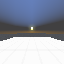

In [6]:
display(Image.fromarray(obs['pov'], ))


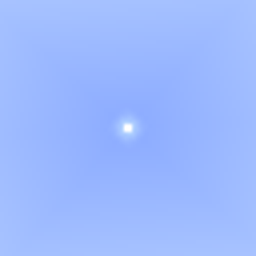

In [7]:
total_reward = 0.
done = False
while not done:
    display(Image.fromarray(obs['pov'],).resize((256, 256)), )
    action = env.action_space.sample()
    # action['camera'][0] *= 0.1
    # action['camera'][0] *= 0.3
    obs, reward, done, info = env.step(action)
    total_reward += reward
    clear_output(wait=True)

In [3]:
from iglu.tasks import RandomTasks


In [48]:
RandomTasks(max_blocks=30, max_dist=5, num_colors=7).sample().target_grid.nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 4,  4,  4,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
         7,  7,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10]),
 array([1, 4, 8, 1, 2, 3, 6, 7, 8, 0, 1, 4, 5, 6, 7, 2, 3, 5, 8, 0, 6, 8,
        2, 3, 4, 6, 8, 1, 4, 7]))

In [39]:
target = RandomTasks(max_blocks=3, max_dist=5, num_colors=3).sample().target_grid #.nonzero()

In [5]:
target.shape

(9, 11, 11)

In [6]:
import torch
from torch.nn.functional import one_hot

target_tensor = one_hot(torch.tensor(target, dtype=torch.long), num_classes=7).permute(3, 0, 1, 2)

In [23]:
from models import TargetEncoder

In [24]:
target_encoder = TargetEncoder()

In [26]:
features = target_encoder(target_tensor[None,:,:,:,:].float())

In [34]:
from models import TargetDecoder

In [35]:
target_decoder = TargetDecoder()

In [37]:
target_decoder(features).shape

torch.Size([1, 7, 9, 11, 11])

In [60]:
# Training procedure
from tqdm.notebook import tqdm

from models import TargetEncoder, TargetDecoder
import torch
from torch import nn
from torch import optim

device = torch.device('cuda')

class TargetAutoencoder(nn.Module):
    def __init__(self):
        super(TargetAutoencoder, self).__init__()
        self.encoder = TargetEncoder()
        self.decoder = TargetDecoder()
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

#target_autoencoder = TargetAutoencoder().to(device)
optimizer = optim.Adam(target_autoencoder.parameters(), lr=1e-4)
loss_function = nn.MSELoss()

n_iterations = 1000
batch_size = 128
for i in tqdm(range(n_iterations)):
    # generate batch
    batch = []
    for _ in range(batch_size):
        target = RandomTasks(max_blocks=30, max_dist=5, num_colors=6).sample().target_grid
        target_tensor = one_hot(torch.tensor(target, dtype=torch.long), num_classes=7).permute(3, 0, 1, 2)[None,:,:,:,:]
        batch.append(target_tensor)
    batch = torch.cat(batch).float().to(device)
    
    optimizer.zero_grad()
    predict = target_autoencoder(batch)
    loss = loss_function(batch, predict)
    loss.backward()
    optimizer.step()
    
    print(i, loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

0 tensor(0.0067, device='cuda:0', grad_fn=<MseLossBackward>)
1 tensor(0.0073, device='cuda:0', grad_fn=<MseLossBackward>)
2 tensor(0.0069, device='cuda:0', grad_fn=<MseLossBackward>)
3 tensor(0.0069, device='cuda:0', grad_fn=<MseLossBackward>)
4 tensor(0.0070, device='cuda:0', grad_fn=<MseLossBackward>)
5 tensor(0.0069, device='cuda:0', grad_fn=<MseLossBackward>)
6 tensor(0.0068, device='cuda:0', grad_fn=<MseLossBackward>)
7 tensor(0.0068, device='cuda:0', grad_fn=<MseLossBackward>)


KeyboardInterrupt: 

In [51]:
target = RandomTasks(max_blocks=3, max_dist=5, num_colors=3).sample().target_grid #.nonzero()
target.shape

(9, 11, 11)

In [52]:
target_tensor = one_hot(torch.tensor(target, dtype=torch.long), num_classes=7).permute(3, 0, 1, 2)

In [54]:
target_tensor.shape

torch.Size([7, 9, 11, 11])